# Calculate SAM index and plot results
- opens all CMIP6 historical model run files with data on surface temperature tas
- open Abram and Marshall data
- calculates the SAM index for the data to test the SAM state in the months before and after Krakatoa 1883


In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import scipy

In [5]:
# import custom functions
import sys 
# sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook
sys.path.append('/g/data/w48/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [6]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/psl/gr1.5/v20200302


psl_Amon_CAS-ESM2-0_historical_r1i1p1f1_gr1.5_185001-201412.nc


In [7]:
import dask.distributed
import tempfile

tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36595 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:39299 Dashboard: http://127.0.0.1:36595/status,Cluster Workers: 4 Cores: 4 Memory: 44.92 GiB


# don't need to run these first cells

## Read in model data

In [8]:
path = '/g/data/w48/kb6999/Models/data_for_plots/'
var = 'psl'

In [ ]:
P40S = xr.open_dataset(f'{path}P40S_{var}.nc').mean(dim='model')
P65S = xr.open_dataset(f'{path}P65S_{var}.nc').mean(dim='model')

## SAM index

In [3]:
# set the dates for the normalisation period
start_date = '1971'
end_date = '2000'

In [4]:
# calculate the anomaly for the normalised zonal mean, x, (x-mean)/std
anom40 = func.monthly_anomaly(P40S, start_date, end_date)
anom65 = func.monthly_anomaly(P65S, start_date, end_date)
anom65

NameError: name 'func' is not defined

In [47]:
# calculate the std for the normalised zonal mean, x, (x-mean)/std
std40 = anom40.sel(time=slice(start_date, end_date)).std(dim='time')
std65 = anom65.sel(time=slice(start_date, end_date)).std(dim='time')
std40

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float64 -39.75
Data variables:
    psl      float64 21.27

In [48]:
# normalise the pressure values by minusing the mean (ie calculating anomaly) and dividing by 30-year average
P40S_n = anom40/std40
P65S_n = anom65/std65

In [57]:
# calculate the SAM index by finding the normalised pressure difference between the two latitude bands
SAM = P40S_n - P65S_n
SAM

<xarray.Dataset>
Dimensions:  (time: 1980)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    psl      (time) float64 -0.2723 -0.8502 0.3011 0.4565 ... 3.971 3.374 5.644

### save data to netcdf

In [15]:
path_models = '/g/data/w48/kb6999/Models/'
path_r = '/g/data/w48/kb6999/Reanalysis/'

In [55]:
with dask.diagnostics.ProgressBar():
    SAM.psl.to_netcdf(f'{path_models}M_SAM_index.nc')

# START HERE

In [ ]:
path_models = '/g/data/w48/kb6999/Models/'
path_r = '/g/data/w48/kb6999/Reanalysis/'

In [19]:
# reopen netcdf and take multi-model mean
SAM = xr.open_dataset(f'{path_models}M_SAM_index.nc')
SAM = SAM.mean(dim='model')
SAM

<xarray.Dataset>
Dimensions:  (time: 1980)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
    month    (time) int64 ...
Data variables:
    psl      (time) float64 -0.4659 -0.5029 -0.127 ... 0.8934 0.6631 1.351

In [20]:
# read in Abram data SAM index
SAM_abram = xr.open_dataset(f'{path_r}SAM_data_abram_1850_2007.nc')
SAM_abram

<xarray.Dataset>
Dimensions:                    (time: 158)
Coordinates:
  * time                       (time) datetime64[ns] 1850-01-01 ... 2007-01-01
Data variables:
    SAM_Index                  (time) float64 ...
    SAM_Index_err              (time) float64 ...
    RE                         (time) float64 ...
    RE_crit                    (time) float64 ...
    SAM_Index_70yloess         (time) float64 ...
    SAM_Index_+error_70yloess  (time) float64 ...
    SAM_Index_-error_70yloess  (time) float64 ...
    Marshall_SAM_Index         (time) float64 ...

# Correlation

In [34]:
def time_diff_corr(dataset, comp_dataset):
    
    # calculate the difference dataset 
    diff = dataset.diff('time')
    diff_comp = comp_dataset.diff('time')
    
    # calculate correlation    
    corr = scipy.stats.pearsonr(diff, diff_comp)
    
    print(corr)
    return 

In [35]:
# compare abram and CMIP6
start_date, end_date = '1850','2007'

# choose CMIP6 data (resampled to yearly) and abram data 
ds = SAM.psl.sel(time=slice(start_date, end_date)).resample(time='YS').mean(dim='time')
ds2 = SAM_abram.SAM_Index.sel(time=slice(start_date, end_date))

# calculate the correlation coefficient using different methods for the largest crossover time period
print(scipy.stats.pearsonr(ds, ds2))#[0]    # Pearson's r
time_diff_corr(ds, ds2)


(0.30813793157875835, 8.190548367133096e-05)
(-0.06167827539125727, 0.44285452303429457)


In [38]:
# compare abram and CMIP6
start_date, end_date = '1873','1893'

# choose CMIP6 data (resampled to yearly) and abram data 
ds = SAM.psl.sel(time=slice(start_date, end_date)).resample(time='YS').mean(dim='time')
ds2 = SAM_abram.SAM_Index.sel(time=slice(start_date, end_date))

# calculate the correlation coefficient using different methods for the largest crossover time period
print(scipy.stats.pearsonr(ds, ds2))#[0]    # Pearson's r
time_diff_corr(ds, ds2)


(-0.15516850638406743, 0.5018279528137298)
(-0.4057446993271213, 0.07590318553054909)


In [36]:
# compare abram and CMIP
start_date, end_date = '1957','2007'

# choose CMIP data (resampled to yearly) and abram data 
ds = SAM.psl.sel(time=slice(start_date, end_date)).resample(time='YS').mean(dim='time')
ds2 = SAM_abram.SAM_Index.sel(time=slice(start_date, end_date))

# calculate the correlation coefficient using different methods for the largest crossover time period
print(scipy.stats.pearsonr(ds, ds2))#[0]    # Pearson's r
# time difference correlation
time_diff_corr(ds, ds2)

(0.34457137681356864, 0.01328366432368937)
(-0.139958324512828, 0.3323426914199519)


In [37]:
# compare marshall and CMIP
start_date, end_date = '1957','2007'

# choose CMIP data (resampled to yearly) and abram data 
ds = SAM.psl.sel(time=slice(start_date, end_date)).resample(time='YS').mean(dim='time')
ds2 = SAM_abram.Marshall_SAM_Index.sel(time=slice(start_date, end_date))

# calculate the correlation coefficient using different methods for the largest crossover time period
print(scipy.stats.pearsonr(ds, ds2))#[0]    # Pearson's r

# time difference correlation
time_diff_corr(ds, ds2)

(0.4004760868740901, 0.003590975919934919)
(0.1595281029217134, 0.2684634421542516)


# figures

In [39]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [40]:
e_date = ['1883-08-27']

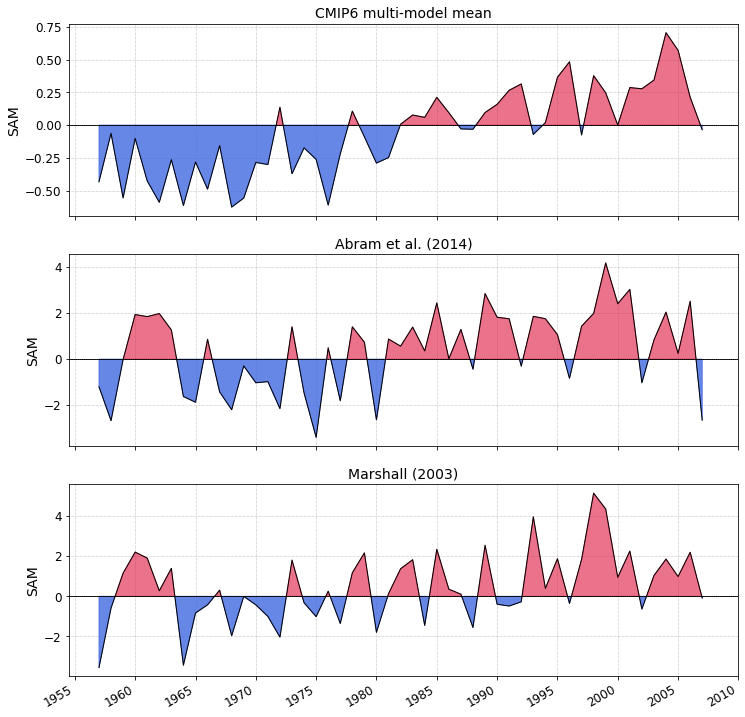

In [45]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12,12))

start_date, end_date = '1957','2007'
ds = SAM.psl.sel(time=slice(start_date, end_date)).resample(time='YS').mean(dim='time')
fplot.SAM_plot(ds, ax = axes[0])

ds1 = SAM_abram.SAM_Index.sel(time=slice(start_date, end_date))
fplot.SAM_plot(ds1, ax = axes[1])

ds2 = SAM_abram.Marshall_SAM_Index.sel(time=slice(start_date, end_date))
fplot.SAM_plot(ds2, ax = axes[2])

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date)-2* pd.offsets.YearBegin(), 
                      pd.to_datetime(end_date)+3* pd.offsets.YearBegin(), freq='5YS')
axes[0].set_xticks(years.values)
axes[0].set_xticklabels(years.year) # .year shows only the year (not month)

# set axis titles
axes[0].set(title = 'CMIP6 multi-model mean')
axes[1].set(title = 'Abram et al. (2014)')
axes[2].set(title = 'Marshall (2003)')

plt.savefig('M_timeseries_year_SAM_compare.png', dpi=300, bbox_inches='tight')

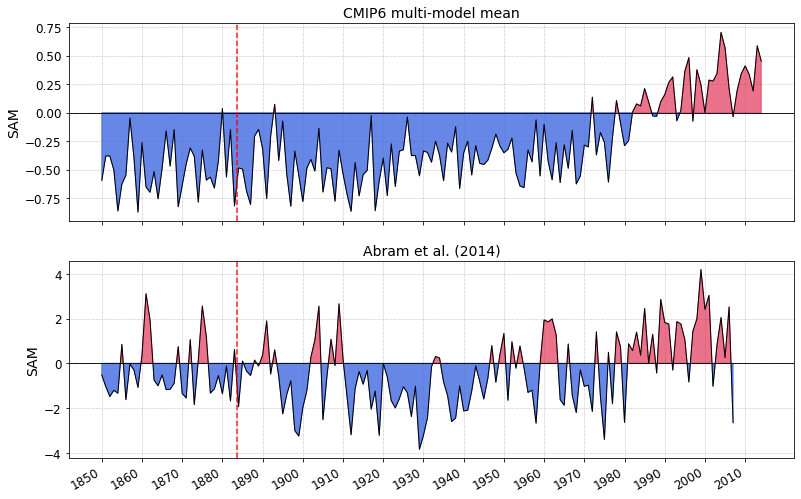

In [44]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(13,8))

start_date, end_date = '1850','2015'
ds = SAM.psl.sel(time=slice(start_date, end_date)).resample(time='YS').mean(dim='time')
fplot.SAM_plot(ds, ax = axes[0], e_date=e_date)

ds1 = SAM_abram.SAM_Index.sel(time=slice(start_date, end_date))
fplot.SAM_plot(ds1, ax = axes[1], e_date=e_date)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='10YS')
axes[0].set_xticks(years.values)
axes[0].set_xticklabels(years.year) # .year shows only the year (not month)

# set axis titles
axes[0].set(title = 'CMIP6 multi-model mean')
axes[1].set(title = 'Abram et al. (2014)')

plt.savefig('M_timeseries_year_SAM_abram+CMIP6_1850-2015.png', dpi=300, bbox_inches='tight')

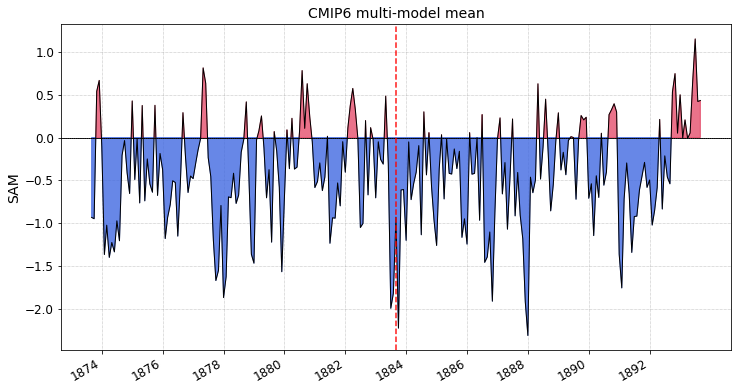

In [43]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))

# select the dataset and years to plot
start_date, end_date = '1873-08','1893-08'
ds = SAM.psl.sel(time=slice(start_date, end_date))

# plot the SAM index
fplot.SAM_plot(ds, ax = axes, e_date=e_date)

#set the frequency of the xticks 
years = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='2YS')
axes.set_xticks(years.values)
axes.set_xticklabels(years.year) # .year shows only the year (not month)

axes.set(title = 'CMIP6 multi-model mean')

plt.savefig('M_K_timeseries_mon_SAM_1873-1893.png', dpi=300, bbox_inches='tight')